In [1]:
import os
import sys
import torch
import numpy as np
from PIL import Image
import PIL.ImageOps as iops
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import clip

sys.path.append('./FastSAM/')


# FastSAM
from FastSAM.fastsam import FastSAM, FastSAMPrompt

In [2]:
device = 'cuda:0'

data_folder = './sample images'
image_files = [os.path.join(data_folder, file_name) for file_name in os.listdir(data_folder)]
image_files = sorted(image_files)

In [22]:
iou_th = 0.9
conf_th = 0.6
in_size = 1024

image_path = image_files[-1]
image_org = Image.open(image_path)
if image_org:
    print('Image loaded successfully')
    print(image_org.size)

wpercent = (in_size / float(image_org.size[0]))
hsize = int((float(image_org.size[1]) * float(wpercent)))
input_image = image_org.resize((in_size, hsize), Image.Resampling.LANCZOS)

Image loaded successfully
(1280, 720)


(1024, 576)


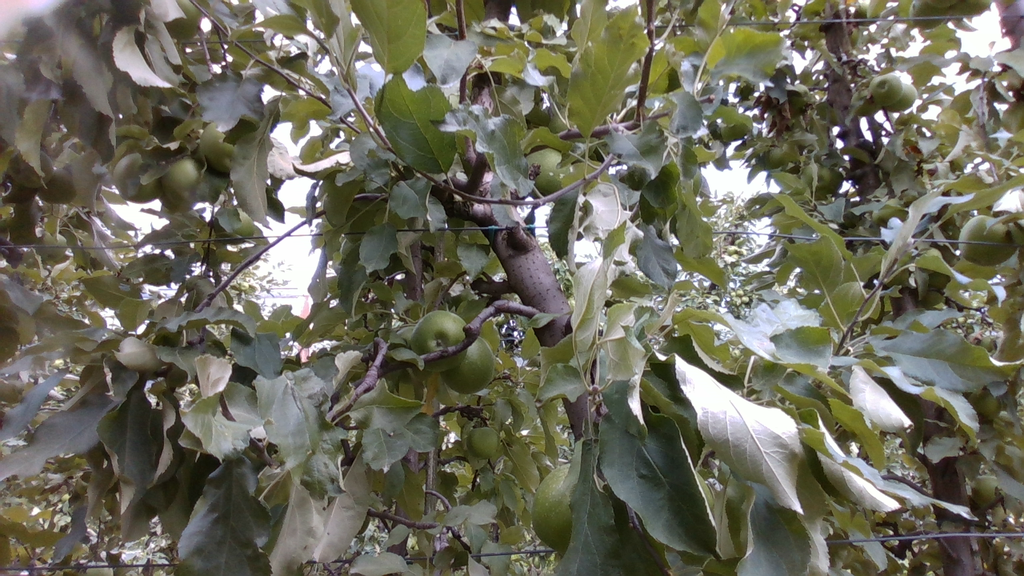

In [23]:
print(input_image.size)
input_image

# Detection part
Detecting the segmentation masks of the objects in the image will be the fisrt step.

In [24]:
model = FastSAM('FastSAM/weights/FastSAM-x.pt')


/data0/atur/ws_staj/AppleDetector/./FastSAM/ultralytics/nn/tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # l

In [25]:
iou_th = 0.9
conf_th = 0.4
in_size = 1024

everything_results = model(input_image,
                        imgsz=in_size,
                        conf=conf_th,
                        iou=iou_th,
                        retina_masks=True,
                        device=device,)
prompt_process = FastSAMPrompt(input_image, everything_results, device=device)


0: 576x1024 59 objects, 52.8ms
Speed: 2.9ms preprocess, 52.8ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)


In [26]:
ann = prompt_process.everything_prompt()

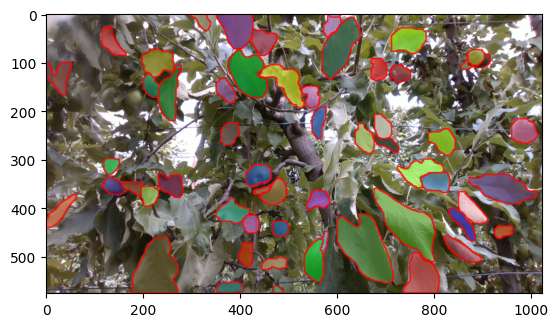

In [27]:
result = prompt_process.plot_to_result(
            ann,
            mask_random_color=True,
            better_quality=True, 
            retina=True, 
            withContours=True,
        )

plt.imshow(result)

In [9]:

format_results = prompt_process._format_results(prompt_process.results[0], 0)
cropped_boxes, cropped_images, not_crop, filter_id, annotations = prompt_process._crop_image(format_results)


# Classification Part
The segments has to be classified into the classes of the objects. Specially to apple and non apple classes. CLIP model is not good with "not" values instead with nouns its better using dummpy classes.

In [10]:
img_arr = np.array(input_image)
clip_images = []
for i in range(len(cropped_images)):
    bbox = cropped_images[i]
    im = Image.fromarray(img_arr[bbox[1]:bbox[3], bbox[0]:bbox[2], :])
    clip_img = iops.pad(im, (256, 256), color='white')
    clip_images.append(clip_img)

In [11]:
clip_model, preprocess = clip.load('ViT-B/32', device=device)




In [12]:
classes = ['an apple',
           'a leaf',
           'a branch',
           'a tree',
           'a net']
text_descriptions = ['a photo of ' + item for item in classes]


preprocessed_images = [preprocess(image).to(device) for image in clip_images]
tokenized_text = clip.tokenize(text_descriptions).to(device)
stacked_images = torch.stack(preprocessed_images)
image_features = clip_model.encode_image(stacked_images)
text_features = clip_model.encode_text(tokenized_text)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
probs = 100.0 * image_features @ text_features.T
logits = probs.softmax(dim=-1)


In [13]:
predictions = torch.argwhere(torch.argmax(logits, dim=1) < 1).squeeze().cpu().numpy()

In [14]:
predictions

array([ 7, 11, 19, 20, 22, 25, 26, 40, 42, 48, 49, 50, 56, 57])

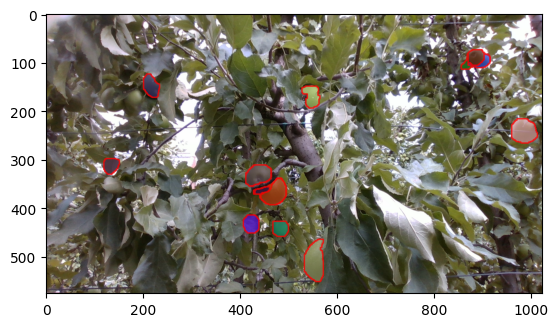

In [15]:
result = prompt_process.plot_to_result(
            ann[predictions],
            mask_random_color=True,
            better_quality=True, 
            retina=True,
            withContours=True,
        )
plt.imshow(result)

In [16]:
selected_bboxes = [cropped_images[i] for i in predictions]

In [17]:
selected_bboxes = np.array(selected_bboxes)
selected_bboxes

array([[ 442,  338,  495,  394],
       [ 960,  216, 1016,  267],
       [ 467,  427,  500,  459],
       [ 532,  464,  574,  554],
       [ 411,  311,  496,  394],
       [ 870,   74,  904,  107],
       [ 200,  124,  234,  173],
       [ 870,   74,  918,  113],
       [ 527,  149,  569,  195],
       [ 118,  298,  151,  331],
       [ 406,  414,  439,  452],
       [ 411,  311,  467,  372],
       [ 856,   74,  917,  115],
       [ 411,  311,  466,  355]])

In [18]:
org_bboxes = (selected_bboxes / wpercent).astype(int)

In [19]:
img_arr = np.array(image_org)
center_pos = []
objects = []
for i in range(len(org_bboxes)):
    bbox = org_bboxes[i]
    center_x = (bbox[0] + bbox[2]) // 2
    center_y = (bbox[1] + bbox[3]) // 2
    center_pos.append((center_x, center_y))
    im = Image.fromarray(img_arr[bbox[1]:bbox[3], bbox[0]:bbox[2], :])
    objects.append(im)
    